## Docs

* https://forums.fast.ai/t/porto-seguro-winning-solution-representation-learning/8499 winning solution porto seguro
* https://github.com/BenjiKCF/Tabular-data-Winning-Solution tabular solution to porto seguro
* To do list
    * To compare other variations of embeddings like using the class information for example

In [8]:
from fastai.tabular.all import *
from fastcore.utils import *
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

df_nn = pd.read_csv('dataset/train.csv', low_memory=False)
df_nn_final = df_nn.drop('id', axis=1)

"""
Categorical embedding
"""

cont,cat = cont_cat_split(df_nn_final, max_card=9000, dep_var='target')
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(seed=23)(df_nn_final)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

to_nn = TabularPandas(df_nn, procs_nn, cat, cont,
                      splits=splits, y_names='target')
dls = to_nn.dataloaders(1024, device = device)

learn = tabular_learner(dls, layers=[500,250], n_out=1)
learn.fit_one_cycle(8, 5e-4)

preds,targs = learn.get_preds()
roc_auc_score(targs, preds)

learn.save('learn8')

# Machine Learning Models
df = pd.read_csv('dataset/train.csv', low_memory=False)
df = df.drop('id', axis=1)
# using the neural net's `cat`, `cont`, and `splits`
procs = [Categorify]
to = TabularPandas(df, procs, cat, cont, 'target', splits = splits)

def rf(xs, y, n_estimators=40, max_samples=130_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf).fit(xs, y)

def auc(m, xs, y):
    preds = m.predict(xs)
    return round(roc_auc_score(y, preds), 3)

# Replacing Nominal variables with Embeddings
learn = learn.load('learn8')

def embed_features(learner, xs):
    """
    learner: fastai Learner used to train the neural net
    xs: DataFrame containing input variables with nominal values defined by their rank.
    ::returns:: a copy of `xs` with embeddings replacing each categorical variable
    """
    xs = xs.copy()
    for i,col in enumerate(learn.dls.cat_names):
        emb = learn.model.embeds[i]
        emb_data = emb(tensor(xs[col], dtype=torch.int64).to(device))
        emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]
        feat_df = pd.DataFrame(data=emb_data, index=xs.index, columns=emb_names)
        xs = xs.drop(col, axis=1)
        xs = xs.join(feat_df)
        return xs
    
emb_xs = embed_features(learn, to.train.xs)
emb_valid_xs = embed_features(learn, to.valid.xs)
emb_valid_xs

epoch,train_loss,valid_loss,time
0,0.146004,0.126564,00:20
1,0.119847,0.116952,00:18
2,0.114580,0.115224,00:16
3,0.112914,0.114094,00:16
4,0.111179,0.112364,00:18
5,0.108029,0.111401,00:16
6,0.106506,0.110684,00:19
7,0.105582,0.110556,00:20


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cat0_0,cat0_1,cat0_2
277491,6,4,2,7,34,1,31,60,1,148,...,0.292775,0.210421,0.335680,0.508110,0.375804,0.485737,0.388535,0.050840,0.04673,0.051745
59826,11,1,1,13,34,3,20,4,13,258,...,0.717059,0.555945,0.253756,0.810781,0.558822,0.821682,0.950494,0.050840,0.04673,0.051745
100532,6,10,1,5,34,3,1,36,1,76,...,0.300573,0.807069,0.559432,0.310892,0.414348,0.328559,0.198210,-0.053597,-0.07647,-0.048948
127444,8,13,1,6,3,1,9,60,1,148,...,0.260020,0.762579,0.929469,0.368868,0.400274,0.582639,0.436348,0.050840,0.04673,0.051745
268466,13,1,2,5,34,1,9,52,5,160,...,0.292645,0.487171,0.581556,0.332349,0.366024,0.374952,0.382322,-0.053597,-0.07647,-0.048948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292950,8,13,1,6,3,5,47,51,1,175,...,0.310330,0.354413,0.335381,0.433126,0.758386,0.438863,0.488459,0.050840,0.04673,0.051745
235306,6,3,1,5,34,3,20,11,1,55,...,0.731341,0.734535,0.548252,0.304629,0.338420,0.321991,0.339444,-0.053597,-0.07647,-0.048948
187628,15,3,1,6,34,1,37,34,1,148,...,0.278301,0.735457,0.787859,0.313780,0.700493,0.799430,0.464530,0.050840,0.04673,0.051745
200243,6,1,2,5,3,1,10,47,5,175,...,0.247176,0.052474,0.172384,0.552959,0.405473,0.266106,0.531018,0.050840,0.04673,0.051745


In [9]:
emb_xs

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cat0_0,cat0_1,cat0_2
155657,2,19,2,5,34,1,36,55,1,149,...,0.297425,0.807528,0.618459,0.134682,0.294103,0.277333,0.328074,0.05084,0.04673,0.051745
173027,6,1,2,5,34,1,47,10,11,70,...,0.611607,0.212078,0.149391,0.564597,0.198777,0.244124,0.552505,0.05084,0.04673,0.051745
4182,12,9,2,6,34,1,40,61,1,250,...,0.604928,0.553467,0.619134,0.601375,0.858435,0.764429,0.922626,0.05084,0.04673,0.051745
85105,13,1,1,6,34,1,40,24,5,160,...,0.603042,0.555548,0.542915,0.292864,0.406706,0.368794,0.321800,0.05084,0.04673,0.051745
239785,11,1,2,6,34,1,12,39,6,211,...,0.474598,0.554855,0.341110,0.438878,0.412705,0.595286,0.329394,0.05084,0.04673,0.051745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156421,11,1,1,6,34,1,40,4,3,178,...,0.572546,0.737983,0.703250,0.788759,0.557523,0.525486,0.836878,0.05084,0.04673,0.051745
175912,8,16,1,6,34,1,47,51,1,175,...,0.320616,0.419490,0.676380,0.400634,0.301467,0.485152,0.451870,0.05084,0.04673,0.051745
108891,12,3,2,5,34,1,15,5,1,76,...,0.287734,0.359661,0.511817,0.362875,0.329639,0.307292,0.392249,0.05084,0.04673,0.051745
203945,9,4,1,5,3,3,19,60,1,70,...,0.248299,0.734260,0.157658,0.325285,0.367817,0.280118,0.459436,0.05084,0.04673,0.051745


In [10]:
emb_valid_xs.shape

(60000, 32)

repeats = [  2,  2,  2,  2,  2,  2,  3,  4,  4, 4,  5]
probas =  [.95, .4, .7, .9, .9, .9, .9, .9, .9, .9, .25]
swap_probas = sum([[p] * r for p, r in zip(probas, repeats)], [])

noise_maker = SwapNoiseMasker(swap_probas)
print(f"the probability vector is of size {sum(repeats)}")


## 2. Test with only Kmeans 
* To do: To test a better algorithme like DCN, deep clusterNet
* Peut être essayer de rajouter un kfold ? Car score à 0.9 pour AUC c'est top délire

In [16]:
# Step 1 - Compute the clusters on the whole data
# Then split it into batch

from utils import *
from sklearn.cluster import KMeans

# --- List of parameters --- #
nb_clust = 40

kmeans = KMeans(n_clusters=nb_clust, random_state=0)

dict_clust = dict()

# -- Clustering -- #
# Retrieve the whole dataset
train_loader, valid_loader = pandas_to_tensor(df, emb_xs, emb_valid_xs)

l_tensor = []

for batch, (x, _) in enumerate(train_loader):
    l_tensor.append(x)
    dict_clust[batch] = dict()
    dict_clust[batch] = len(x)

concat_tensors = torch.cat(l_tensor, dim=0)

# Cluster the whole dataset
clust_train = kmeans.fit_predict(concat_tensors)

i = iter(clust_train)

dico_cluster = {k: [next(i) for _ in range(v)] for k, v in dict_clust.items()}

In [17]:
from torch.utils.data import Dataset

import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as opt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from utils import *


class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        """
        To add dropout or other idk
        input_size: df.shape[1]
        output_size: nb_clust
        """
        #self.fc1 = nn.Linear(in_features =input_size, out_features = 20)
        self.fc1 = nn.Linear(in_features =input_size, out_features = output_size)

        #self.fc2 = nn.Linear(in_features = 20, out_features=output_size)
        self.fc3 = nn.Linear(in_features=output_size, out_features=1)
        
        self.bn1 = nn.BatchNorm1d(num_features=output_size)
        self.bn2 = nn.BatchNorm1d(num_features=output_size)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        
    def forward(self, x, n_clusters):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        #x = self.fc2(x)
        #x = self.bn2(x)
        #x = self.relu(x)
        #x = self.dropout(x)
        
        if n_clusters == 2:
            # binary classification
            # returns a probability scalar
            x = self.fc3(x)
            return x
            
        else:
            # clustering
            # return a vector of size number of clusters
            #x = self.fc2(x)
            return x
    

train_loader, valid_loader = pandas_to_tensor(df, emb_xs, emb_valid_xs)

#nb_clust = 15

# -1 cause we remove the target
net = Net(32, nb_clust)


max_epochs = 2
#loss_fct = nn.CrossEntropyLoss()
loss_fct_binary = nn.BCEWithLogitsLoss()
loss_fct_clustering = nn.CrossEntropyLoss()

l_loss = list()
l_loss_intermediate = list()
l_loss_test = list()
l_roc_train = list()
l_roc_intermediary = list()
l_roc_test = list()

optim = opt.Adam(net.parameters(), lr=0.1)


for epoch in tqdm(range(max_epochs)):
    """
    Unsupervised: Pre-learning we learn with the pseudo labels from clustering
    """
    t0 = datetime.now()
    net.train()
    for batch, (x, _) in enumerate(train_loader):
        optim.zero_grad()
        #x, mask = noise_maker.apply(x)
        # Predict soft-targets and embeddings
        output = net(x, nb_clust)
        
        # negative log likelihood
        m = nn.Softmax(dim=1)
        pseudo_labels = np.array(dico_cluster[batch])
        # note that in the loss I used to do m(output) that is re apply a softmax -> not necessary I think
        loss = loss_fct_clustering(output, torch.tensor(pseudo_labels.astype(np.int8), dtype=torch.long))

        loss.backward()
        optim.step()
        
        l_loss.append(loss.item())
        #l_roc_train.append(roc_auc_score(y.detach().numpy(), proba.detach().numpy()))

100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


In [18]:
for name, param in net.named_parameters():
    if param.requires_grad and 'fc1' in name:
        param.requires_grad = False
    elif param.requires_grad and 'fc2' in name:
        param.requires_grad = False

optim = opt.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01)

max_epochs = 25

for epoch in tqdm(range(max_epochs)):
    """
    Supervised: Second batch we learn to predict binary classification problem
    """
    t0 = datetime.now()
    net.train()
    for batch, (x, y) in enumerate(train_loader):
        optim.zero_grad()

        output = net(x, 2)
        
        loss = loss_fct_binary(output, y)

        loss.backward()
        optim.step()
        
        l_loss_intermediate.append(loss.item())
        l_roc_intermediary.append(roc_auc_score(y.detach().numpy(),  torch.sigmoid(output).detach().numpy()))
        

100%|███████████████████████████████████████████| 25/25 [01:12<00:00,  2.90s/it]


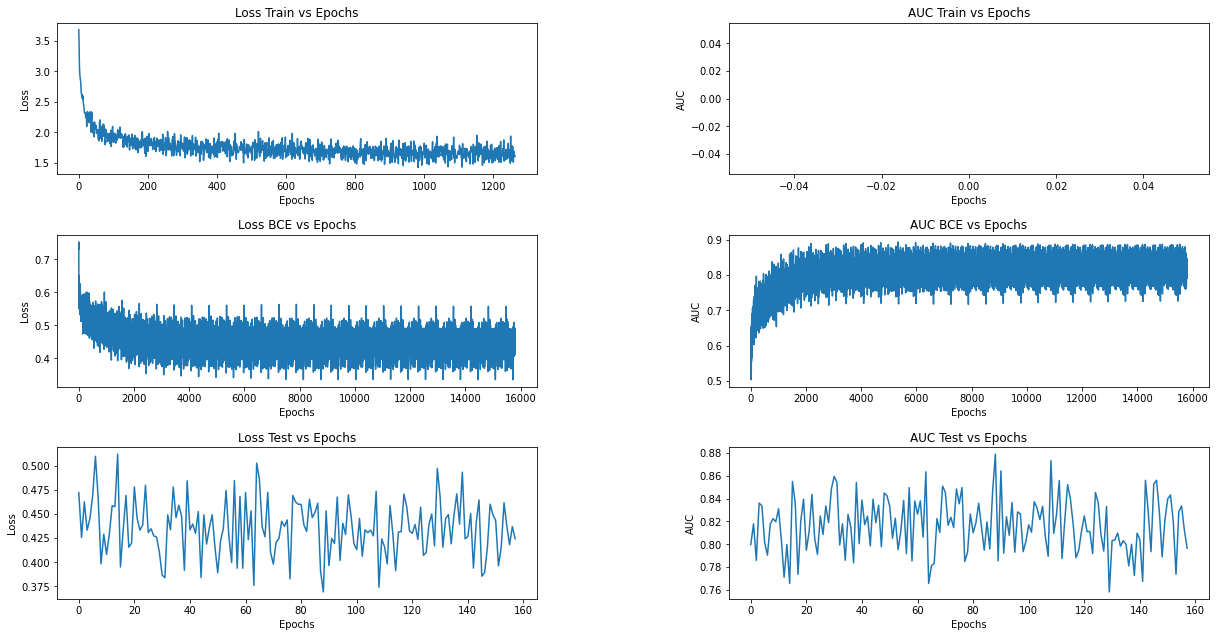

<Figure size 1600x800 with 0 Axes>

In [19]:
with torch.no_grad():
    """
    Testing
    """
    for batch, (x, y) in enumerate(valid_loader):
        output = net(x, 2)

        loss = loss_fct_binary(output, y)
        l_loss_test.append(loss)
        
        l_roc_test.append(roc_auc_score(y.detach().numpy(), torch.sigmoid(output).detach().numpy()))
        
print_scores(l_loss, l_roc_train,l_loss_intermediate, l_roc_intermediary, l_roc_test, l_loss_test)